# 분석을 위한 데이터 핸들링 하기

빠른 분석을 위해 몇가지 조건으로 데이터를 처리하겠습니다. 
- 칼럼 이름을 한글로 변경
- 이주일치만 남기기 - 빠른 분석을 위함
- A03에서 구매한 사람의 데이터만 구성
- 한번도 구매 안한사람 제외 
- 아이템을 영어에서 한글로 바꿈
- 간단한 전처리

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import warnings
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tq
pd.set_option('display.max_row',300)
%matplotlib inline
warnings.filterwarnings(action='ignore')

In [50]:
path=os.getenv("HOME") + ('/repo/Hackathon/Lpoint Competition/data/')
filename = ["01.Grade_online.csv",  "02.Transaction.csv","04.demographic.csv", "03.Product classification.csv"]

In [51]:
online = pd.read_csv(path + filename[0])
trade = pd.read_csv(path + filename[1])
customer = pd.read_csv(path + filename[2])
item = pd.read_csv(path + filename[3])

## 칼럼 이름을 한글로 변경

데이터의 칼럼 명이 영어로 되어 있어서 직관적인 이해를 방해한다고 생각했습니다.  
그래서 간단하게 칼럼을 한글로 바꿨습니다.

In [52]:
online.columns = ['고객', '세션', '조회번호', '행동', '상점', '날짜','조회시각', '경과시간', '거래정보', '키워드', '총뷰', '총세션', '경로', '장비', '등급']
trade.columns = ['고객', '거래정보', '거래번호', '상점', '상품', '구매일자','구매시간', '구매금액', '구매수량']
customer.columns = ['고객', '성별', '나이']
item.columns = ['상품', '대분류', '중분류', '소분류']

In [53]:
online.head()

,고객,세션,조회번호,행동,상점,날짜,조회시각,경과시간,거래정보,키워드,총뷰,총세션,경로,장비,등급
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14,124,unknown,mobile_app,6.0
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14,124,unknown,mobile_app,6.0
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14,124,unknown,mobile_app,6.0
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45,424,unknown,mobile_app,6.0
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45,424,unknown,mobile_app,6.0


In [54]:
online.shape

(3196362, 15)

### 데이터를 이주일치만 남기기

분석을 하다보면 많은 데이터의 양이 불필요한 시간낭비를 초래합니다.  
그래서 3개월이 아닌 2주만 남기고 데이터를 정리했습니다. 

In [55]:
online_week = online[online['날짜'] < 20190715]
online_week = online_week.sort_values(by='날짜')
online_week.shape

(515904, 15)

### A03을 제외한 row 제거

온라인 데이터에서는 총 3군데 (A01, A02, A03)의 상점 정보가 있습니다.  
이 중에서 A03만 남기고 제외하겠습니다.

In [56]:
online_week = online_week[online_week['상점'] == 'A03']

In [57]:
online_week.shape

(375281, 15)

### 영어에서 한글로 바꿈

키워드는 한글로 되어있는 반면, 상품 정보는 영어로 되어 있습니다.  
추후에 키워드와 상품 정보의 상관 관계를 파악하기 위해서 한글로 변경하겠습니다. 

In [58]:
item.head()

,상품,대분류,중분류,소분류
0,1,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Automobile Oil / Additives
1,2,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Lights
2,3,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Paint
3,4,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Filters
4,5,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Wiper Blades


In [64]:
papago = pd.read_csv('csv/papago.csv', header=None)
item['소분류'] = papago[0]
item.head()

,상품,대분류,중분류,소분류
0,1,Automotive Products,Automotive Replacement Repair / Maintanance Kits,자동차 오일/첨가물
1,2,Automotive Products,Automotive Replacement Repair / Maintanance Kits,카 라이트
2,3,Automotive Products,Automotive Replacement Repair / Maintanance Kits,카 페인트
3,4,Automotive Products,Automotive Replacement Repair / Maintanance Kits,필터
4,5,Automotive Products,Automotive Replacement Repair / Maintanance Kits,와이퍼 블레이드


In [89]:
item['소분류'][963] = '닭고기 달걀'
item['소분류'] = item['소분류'].fillna('nan')

In [90]:
item['소분류'].isna().sum()

0

### 간단한 전처리

앞선 전처리 이외에도 처리가 안된 데이터를 정리해줍니다.

In [91]:
import matplotlib.font_manager as fm
%matplotlib inline
warnings.filterwarnings(action='ignore')
path = 'DATA/font/NanumGothic-ExtraBold.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [92]:
customer.loc[customer['성별']=='unknown','성별'] = np.NaN
customer['성별'] = customer['성별'].astype('category')

customer.loc[customer['나이']=='unknown','나이'] = np.NaN
customer['나이'] = customer['나이'].astype(float)

<AxesSubplot:>

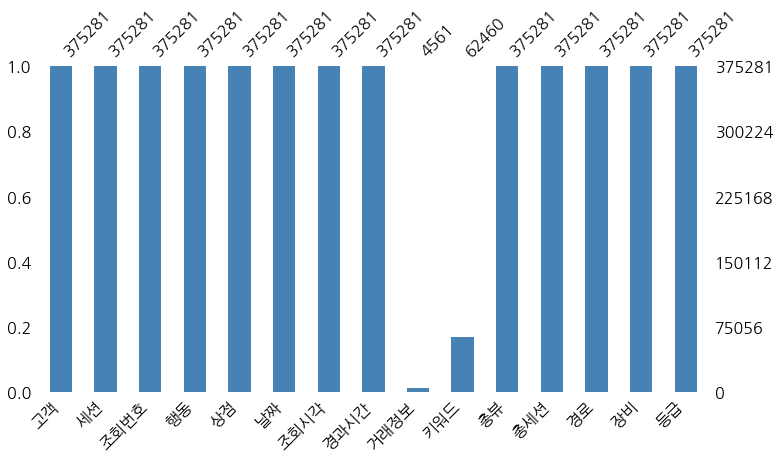

In [93]:
msno.bar(online_week, figsize=(12,6), color='steelblue')

## 데이터 합치기

간단한 분석을 위해서 필요한 칼럼만 추출하고 merge하겠습니다.  
이때 4개의 데이터를 합쳐서 한개의 데이터로 만들어줍니다. 

In [94]:
trade_int = trade.copy()
trade_int = trade_int[trade_int['상품'] != 'unknown']
trade_int['상품'] = trade_int['상품'].astype(np.int64)

In [95]:
online_col = ['고객', '세션', '조회번호', '행동', '경과시간', '거래정보', '키워드', '총뷰', '총세션', '경로', '장비', '등급']
trade_col = ['거래정보', '상점', '상품', '구매일자','구매시간', '구매금액', '구매수량']
customer_col = ['고객', '성별', '나이']
item_col = ['상품', '소분류']

In [96]:
temp = pd.merge(online_week[online_col], trade_int[trade_col], on='거래정보')
temp = pd.merge(temp, customer[customer_col], on='고객')
df_data = pd.merge(temp, item[item_col], on='상품')

df_data= df_data.drop(['세션', '거래정보', '상점', '상품' , '조회번호', '구매시간'], axis = 1)
df_data.head()

,고객,행동,경과시간,키워드,총뷰,총세션,경로,장비,등급,구매일자,구매금액,구매수량,성별,나이,소분류
0,9,6,1853427,NaN,40,1903,DIRECT,unknown,5.0,20190708,1000,1,F,40.0,쿠키
1,536,6,937000,NaN,39,2774,PUSH,unknown,4.0,20190702,3690,1,M,40.0,쿠키
2,536,6,937000,NaN,39,2774,PUSH,unknown,4.0,20190702,1690,1,M,40.0,쿠키
3,536,6,795971,NaN,39,803,PUSH,unknown,4.0,20190711,1150,1,M,40.0,쿠키
4,536,6,795971,NaN,39,803,PUSH,unknown,4.0,20190711,1990,1,M,40.0,쿠키


## 데이터 저장

In [97]:
online_week = online_week.sort_values(['고객','세션','조회번호'])
online_week.to_csv('./new_data/new_online.csv', index=False)

trade = trade.sort_values(['고객','거래정보','거래번호'])
trade.to_csv('./new_data/new_trade.csv',index=False)

item.to_csv('./new_data/new_item.csv',index=False)

customer.to_csv('./new_data/new_customer.csv',index=False)

In [98]:
df_data = df_data.sort_values(['구매일자'])
df_data.to_csv('./new_data/df_data.csv',index=False)